# Theme 3: Deep Learning Hands-On Walkthrough

This notebook allows us to step through the logic of `solve_theme3.py` interactively.
We will explore:
1. Data Loading & Preprocessing
2. Building a simple Linear Classifier (Single Layer Neural Network)
3. The effects of Training Duration (Epochs)
4. Visualizing Neural Network Weights
5. Regularization (L2)
6. Deepening the Network (Adding Hidden Layers)
7. Activation Functions

## Self-Learning Goal
The goal here is not just to run code, but to understand *why* each step is necessary and what the output tells us about the model's learning process.


## 1. Imports

We use `numpy` for data manipulation, `tensorflow/keras` for building neural networks, `PIL` for image handling, and `matplotlib` for visualization.


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import regularizers
from PIL import Image
import matplotlib.pyplot as plt
import os

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 2. Helper Functions

In Deep Learning, data plumbing is often 80% of the work. We need robust functions to:
- **Load Labels**: Read class IDs from text files.
- **Load Images**: Read image files into NumPy arrays.
- **Normalize**: Scale pixel values to a small range (e.g., -1 to 1 or 0 to 1) to help the optimizer converge.
- **Split**: Separate data into Testing and Validation sets to ensure we don't cheat by optimizing on our test data.

*Self-Learning Note*: Notice `normalize_dataset`. It shifts data to be 0-centered (approx) by subtracting 128 and dividing by 128. This helps gradient descent steps be more uniform.


In [24]:
# --- Helper Functions ---
def load_labels(filename):
    with open(filename,'r') as file:
       li = file.readlines()
    label_count = len(li)
    labels = np.empty((label_count,1), dtype='int')
    i = 0
    with open(filename) as f:
        for line in f:
            labels[i] = int(line.replace("\n", ""))
            i = i + 1
    return labels

def load_images(folder, image_count, image_size):
    array_shape = (image_count, image_size[0], image_size[1], image_size[2])
    imageset = np.empty(array_shape, dtype='float')
    for i in range(0,image_count):
        fname = os.path.join(folder, 'image_' + "{:04d}".format(i) + '.png')
        if not os.path.exists(fname):
             print(f"Warning: File {fname} not found.")
             continue
        image = Image.open(fname)
        imageset[i] = np.asarray(image)
    return imageset

def normalize_dataset(sampled_images):
    # Scale to range [-1, 1] approx
    sampled_images = (sampled_images.astype('float32')-128) / 128
    return sampled_images

def split_test_val(data, splitpoint):
    # Returns (Tail, Head) - careful with indices!
    return data[splitpoint:], data[:splitpoint]

def create_model(input_shape, dense_size, classes, l2_reg=None):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    
    if l2_reg:
        y = Dense(classes, activation='softmax', name='dense_layer', kernel_regularizer=l2_reg)(y)
    else:
        y = Dense(classes, activation='softmax', name='dense_layer')(y)
        
    model = Model(inputs=x, outputs=y)
    return model

def create_model_2_layers(input_shape, dense_size, classes):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    # Task 7: 2nd dense layer usually adds 'depth' allowing complex features
    y = Dense(dense_size, activation='relu')(y)
    y = Dense(classes, activation='softmax', name='dense_layer_out')(y)
    model = Model(inputs=x, outputs=y)
    return model

def visualize_weights(model, layer_name, title, filename):
    try:
        weights, biases = model.get_layer(layer_name).get_weights()
    except ValueError:
        print(f"Layer {layer_name} not found or has no weights")
        return

    # Weights shape: (InputDim, Units) -> (3072, 10)
    input_shape = (32, 32, 3)
    n_units = weights.shape[1]
    
    # We want to show the weights for each class (unit)
    rows = 2
    cols = 5 
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    
    for i, ax in enumerate(axes.flat):
        if i >= n_units:
            break

        weight_vector = weights[:, i]
        # Reshape: (3072,) -> (32, 32, 3)
        weight_image = weight_vector.reshape(input_shape)

        # Normalize to 0-1 for display
        min_val = weight_image.min()
        max_val = weight_image.max()
        weight_image = (weight_image - min_val) / (max_val - min_val + 1e-5)

        ax.imshow(weight_image)
        ax.set_title(f'Class {i}')
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show() # Changed from savefig to show for notebook
    print(f"Visualization generated.")


## 3. Loading Data

We load the CIFAR-10 subset.
We assume the `resources` folder is in the current working directory.


In [23]:
print("--- Loading Data ---")
base_res = 'resources' # Assumed relative to CWD
if not os.path.exists(base_res):
    print(f"ERROR: '{base_res}' directory not found. Please ensure you are in the correct directory.")
else:
    # 1. Load Labels
    y_train = load_labels(os.path.join(base_res, 'training/labels.csv'))
    
    # 2. Load Images (based on how many labels we have)
    x_train_raw = load_images(os.path.join(base_res, 'training'), len(y_train), (32,32,3))
    
    Y_test = load_labels(os.path.join(base_res, 'testing/labels.csv'))
    X_test_raw = load_images(os.path.join(base_res, 'testing'), len(Y_test), (32,32,3))

    print("Data Loaded.")

--- Loading Data ---
Data Loaded.


## 4. Normalization & Splitting

**Normalization**: Raw pixel values are 0-255. Neural networks prefer inputs near 0 with unit variance. We subtract 128 and divide by 128.

**Splitting**: We split the 'Test' set folder into a true 'Test' set and a 'Validation' set.
- **Validation**: Used during training to check progress.
- **Test**: Used ONLY at the very end to report final performance.


In [5]:
x_train = normalize_dataset(x_train_raw)
X_test = normalize_dataset(X_test_raw)

# Splitting logic from original script
# index 0 to 2000 -> Validation
# index 2000 to End -> Test
splitpoint = 2000
x_test, x_val = split_test_val(X_test, splitpoint)
y_test, y_val = split_test_val(Y_test, splitpoint)

class_count = len(np.unique(y_train))
dims = (32, 32, 3)
dense_sz = 100

print(f"Training set: {x_train.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")
print(f"Classes: {class_count}")

Training set: (10000, 32, 32, 3)
Validation set: (2000, 32, 32, 3)
Test set: (3000, 32, 32, 3)
Classes: 10


## 5. Task 3: Baseline Model (5 Epochs)

We create a simple model: `Input -> Flatten -> Dense (Softmax)`.
This is effectively Multinomial Logistic Regression.
It has no "hidden" layers, so it can only learn linear boundaries between classes.

We train for just 5 epochs to sanity check that learning happens.


In [31]:
print("\n--- Task 3 (Standard Model 5 epochs) ---")
model = create_model(dims, dense_sz, class_count)
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
model.summary()

l1 = model.get_layer('dense_layer')
w, b = l1.get_weights()
print(f"Linear Layer Weights shape: {w.shape}")

history5 = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val), verbose=2)
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy (5 epochs): {score[1]}')


--- Task 3 (Standard Model 5 epochs) ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

Linear Layer Weights shape: (3072, 10)
Epoch 1/5
313/313 - 1s - 3ms/step - accuracy: 0.1970 - loss: 2.2215 - val_accuracy: 0.2705 - val_loss: 2.0448
Epoch 2/5
313/313 - 0s - 1ms/step - accuracy: 0.2918 - loss: 2.0085 - val_accuracy: 0.3160 - val_loss: 1.9587
Epoch 3/5
313/313 - 0s - 2ms/step - accuracy: 0.3271 - loss: 1.9377 - val_accuracy: 0.3335 - val_loss: 1.9168
Epoch 4/5
313/313 - 1s - 2ms/step - accuracy: 0.3426 - loss: 1.8960 - val_accuracy: 0.3495 - val_loss: 1.8914
Epoch 5/5
313/313 - 1s - 2ms/step - accuracy: 0.3550 - loss: 1.8668 - val_accuracy: 0.3580 - val_loss: 1.8731
Test accuracy (5 epochs): 0.35866665840148926


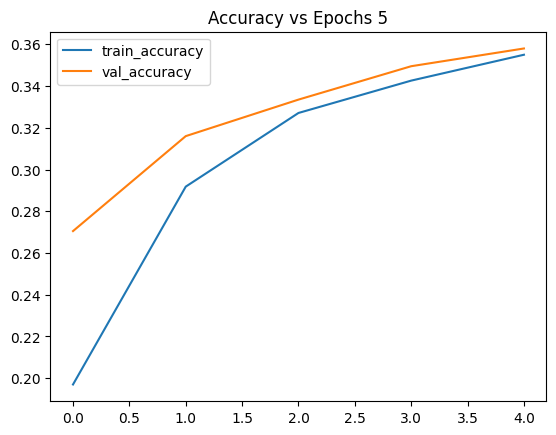

In [36]:
plt.figure()
plt.plot(history5.history['accuracy'], label='train_accuracy')
plt.plot(history5.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy vs Epochs 5')
plt.legend()
plt.show()

## 6. Task 4: Extended Training (100 Epochs)

5 Epochs is rarely enough. Let's train for 100 epochs and plot the history.

**Self-Learning Observation**:
- If `train_acc` keeps going up but `val_acc` plateaus or goes down, we are **overfitting**.
- If both are low, we are **underfitting**.



--- Task 4 (Standard Model 100 epochs) ---


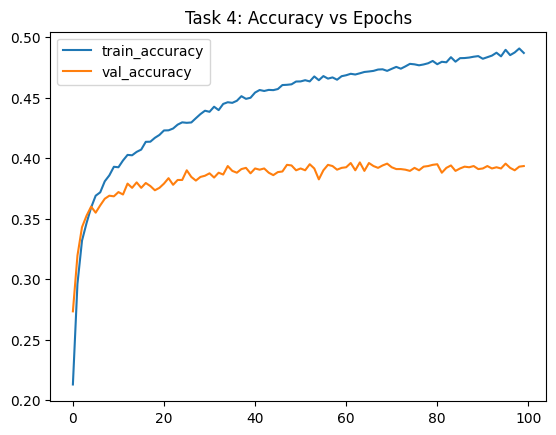

Final Train Acc: 0.4869
Final Val Acc: 0.3935


In [29]:
print("\n--- Task 4 (Standard Model 100 epochs) ---")
model_t4 = create_model(dims, dense_sz, class_count)
model_t4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
history = model_t4.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), verbose=0)

plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Task 4: Accuracy vs Epochs')
plt.legend()
plt.show()

print(f"Final Train Acc: {history.history['accuracy'][-1]:.4f}")
print(f"Final Val Acc: {history.history['val_accuracy'][-1]:.4f}")

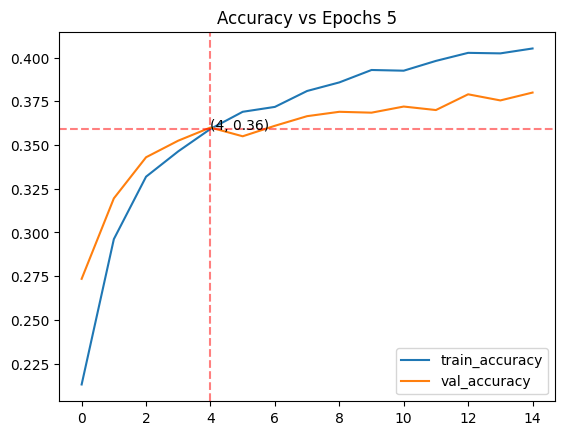

In [38]:
history15_acc = history.history["accuracy"][:15]
history15_val_acc = history.history["val_accuracy"][:15]
plt.figure()
plt.plot(history15_acc, label='train_accuracy')
plt.plot(history15_val_acc, label='val_accuracy')

cross_idx = np.argmin(np.abs(np.array(history15_acc) - np.array(history15_val_acc)))
plt.axvline(x=cross_idx, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=history15_acc[cross_idx], color='r', linestyle='--', alpha=0.5)
plt.text(cross_idx, history15_acc[cross_idx], f'({cross_idx}, {history15_acc[cross_idx]:.2f})')

plt.title('Accuracy vs Epochs 5')
plt.legend()
plt.show()

## 7. Task 5: Visualizing Weights

Since we have a linear model (no hidden layers), the weights connecting the input pixels to a class can be interpreted as a "feature template".
If the model thinks a "Car" looks like a blob with wheels, the weights for the "Car" class will look like a ghost image of a car.

**Observation**: High noise in these images suggests the model is memorizing statisical noise rather than learning robust features.



--- Task 5 (Visualization) ---


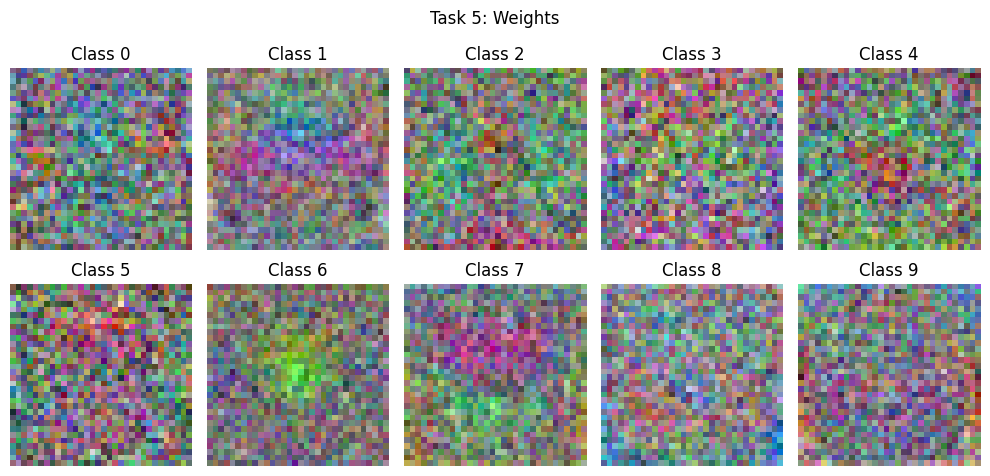

Visualization generated.


In [8]:
print("\n--- Task 5 (Visualization) ---")
visualize_weights(model_t4, 'dense_layer', 'Task 5: Weights', 'task5_weights.png')

## 8. Task 6: L2 Regularization

To reduce noise and overfitting, we apply **L2 Regularization**.
This forces weights to be small. Large weights usually mean the model is trying too hard to fit specific noisy pixels. Small weights imply a smoother, more general solution.

**Expectation**:
- Weights should look "smoother" or "blurrier" in visualization.
- Validation accuracy might improve (or at least the gap between train/val should close).



--- Task 6 (L2 Regularization) ---


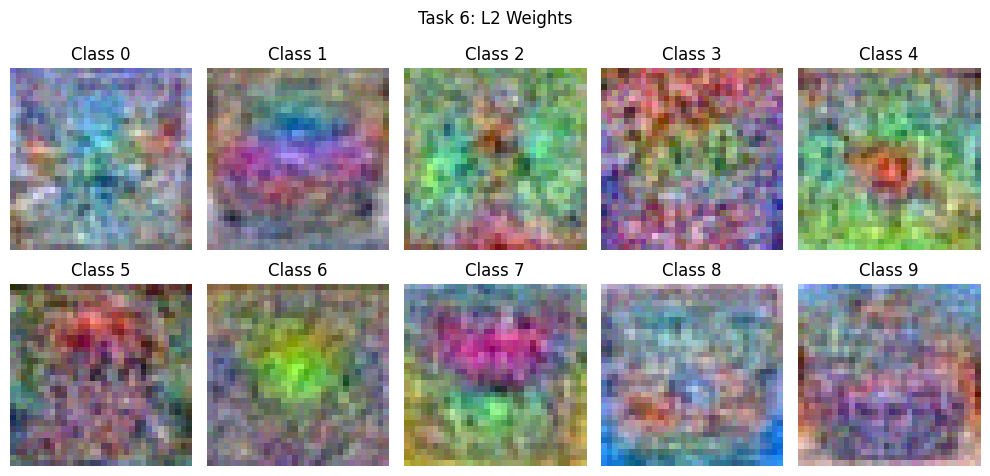

Visualization generated.


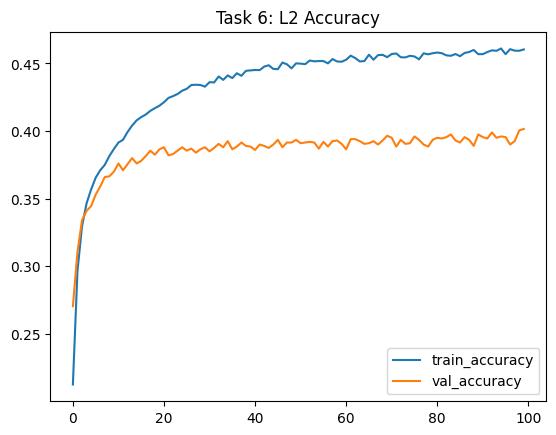

Test accuracy (L2, 100 epochs): 0.4073333442211151


In [ ]:
print("\n--- Task 6 (L2 Regularization) ---")
model_l2 = create_model(dims, dense_sz, class_count, l2_reg=regularizers.L2(0.03))
model_l2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
history_l2 = model_l2.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), verbose=0)

# Visualize new weights
visualize_weights(model_l2, 'dense_layer', 'Task 6: L2 Weights', 'task6_weights.png')

score_l2 = model_l2.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy (L2, 100 epochs): {score_l2[1]}')

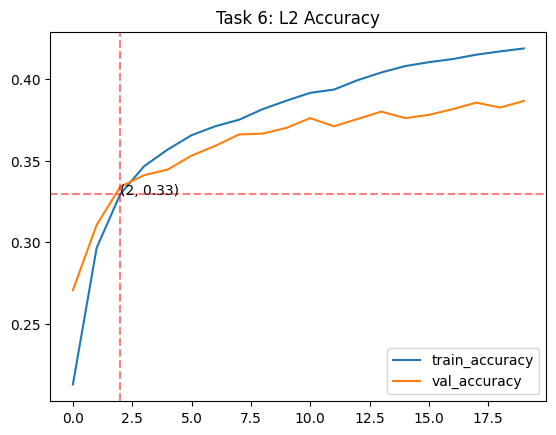

In [41]:
history20_acc = history_l2.history['accuracy'][:20]
history20_val_acc = history_l2.history['val_accuracy'][:20]

plt.figure()
plt.plot(history20_acc, label='train_accuracy')
plt.plot(history20_val_acc, label='val_accuracy')

cross_idx = np.argmin(np.abs(np.array(history20_acc) - np.array(history20_val_acc)))
plt.axvline(x=cross_idx, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=history20_acc[cross_idx], color='r', linestyle='--', alpha=0.5)
plt.text(cross_idx, history20_acc[cross_idx], f'({cross_idx}, {history20_acc[cross_idx]:.2f})')

plt.title('Task 6: L2 Accuracy')
plt.legend()
plt.show()


## 9. Task 7: Two-Layer Network

Linear models can't solve XOR problems or understand hierarchical features.
We add a helper layer (Hidden Layer) with `ReLU` activation.
`Input -> Flatten -> Dense(100, ReLU) -> Dense(10, Softmax)`

This usually boosts accuracy significantly (e.g., +10%).


In [10]:
print("\n--- Task 7 (2 Layers) ---")
model_2l = create_model_2_layers(dims, dense_sz, class_count)
model_2l.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
history_2l = model_2l.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), verbose=0)
score_2l = model_2l.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy (2 Layers, 100 epochs): {score_2l[1]}')


--- Task 7 (2 Layers) ---
Test accuracy (2 Layers, 100 epochs): 0.4593333303928375


## 10. Task 8: Activation Functions Demo

Different activations have different properties:
- **Sigmoid**: Squisies output to [0, 1]. Can cause vanishing gradients.
- **ReLU**: `max(0, x)`. Fast, solves vanishing gradient for positive values.
- **LeakyReLU**: allows small negative gradient to flow.

Let's test them on a dummy matrix.


In [43]:
print("\n--- Task 8 (Activations Demo) ---")
input_mat = np.array([[-1, 0, 1, 2], [-2, 0, 1, 2], [10, 15, 20, 30], [-20, -10, -5, -1]]).astype(np.float32)
print(input_mat)

def demo_activation(name, func):
    out = func(input_mat)
    print(f"Activation: {name}")
    print(out.numpy())

demo_activation('ReLU', keras.activations.relu)
demo_activation('Sigmoid', keras.activations.sigmoid)
l_relu = keras.layers.LeakyReLU(negative_slope=0.1)
out_lrelu = l_relu(input_mat)
print("Activation: LeakyReLU (0.1)")
print(out_lrelu.numpy())


--- Task 8 (Activations Demo) ---
[[ -1.   0.   1.   2.]
 [ -2.   0.   1.   2.]
 [ 10.  15.  20.  30.]
 [-20. -10.  -5.  -1.]]
Activation: ReLU
[[ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [10. 15. 20. 30.]
 [ 0.  0.  0.  0.]]
Activation: Sigmoid
[[2.6894140e-01 5.0000000e-01 7.3105854e-01 8.8079709e-01]
 [1.1920294e-01 5.0000000e-01 7.3105854e-01 8.8079709e-01]
 [9.9995458e-01 9.9999970e-01 1.0000000e+00 1.0000000e+00]
 [2.0611541e-09 4.5397861e-05 6.6928524e-03 2.6894140e-01]]
Activation: LeakyReLU (0.1)
[[-0.1  0.   1.   2. ]
 [-0.2  0.   1.   2. ]
 [10.  15.  20.  30. ]
 [-2.  -1.  -0.5 -0.1]]
